# Criação do modelo de machine learning

Nessa seção será utilizado algoritmos de machine learning, a fim de analisar os sentimentos contidos nos tweets dos candidatos, além de validar a acurácia do modelo proposto

In [1]:
#IMPORTA LIBRARIES
import os
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nltk
import re
import string
import unidecode
from string import punctuation
from nltk import tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download("stopwords") 
token_espaco = tokenize.WhitespaceTokenizer()

sns.set_theme(style="whitegrid")
sns.set(font="Arial")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\evert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Importar e tratar dataset

In [2]:
#importar linhas do arquivo
#caminho do arquivo
file_path = "D:\\PUC_MINAS\\TCC\\Dataset\\tweet_candidatos_eleicoes_2018.csv"

def importa_linhas():
    list_rows = []
    with open(file_path, "r", encoding='utf-8') as f:
        rows = csv.reader(f, delimiter=';')
        for i, row in enumerate(rows):
            if(i > 0):
                list_rows.append(row)
    return list_rows
rows = importa_linhas()
df = pd.DataFrame(rows, columns = ['tweet','num_retweets','num_likes','user','data','data_resumo','dia_semana','mensagem'])

df.head(5)

,tweet,num_retweets,num_likes,user,data,data_resumo,dia_semana,mensagem
0,NAÇÃO BRASILEIRA. Conh...,55,839,cabodaciolo,2018-10-27,27/10,Sab,NAÇÃO BRASILEIRA. Conh...
1,Seguirei o caminho da integridade;quando virás...,59,1094,cabodaciolo,2018-10-27,27/10,Sab,Seguirei o caminho da integridade;quando virás...
2,https://t.co/BvTWDIZdiO,893,6128,cabodaciolo,2018-10-20,20/10,Sab,
3,Voto em cédulas JÁ!Glória a Deus https://t.co/...,107,871,cabodaciolo,2018-10-20,20/10,Sab,Voto em cédulas JÁ!Glória a Deus
4,@isamovitz Deus abençoe,0,12,cabodaciolo,2018-10-18,18/10,Qui,@isamovitz Deus abençoe


### Os tweets serão tratados retirando as pontuações e stopwords

Nesse caso também não será necessário analisar termos com # ou @, pois não tem valor para a análise feita

In [3]:
#Retirar termos com # ou @
def retirar_texto_com_arroba_hashtag_outros(texto):
    #excluir conteudos com @ e #
    caracteres = ['@','#']
    nova_msg = list()
    for t in texto:
        frase = list()
        conteudo_msg = token_espaco.tokenize(t)
        for msg in conteudo_msg:
            if msg[0] not in caracteres:
                  frase.append(msg)
        nova_msg.append(' '.join(frase))
    return nova_msg

df["mensagem"] = retirar_texto_com_arroba_hashtag_outros(df["mensagem"])


print("Frase tratada:\n")
print(df["mensagem"][0])

Frase tratada:

NAÇÃO BRASILEIRA. Conheço as suas obras, sei que você não é frio nem quente. Melhor seria que fosse frio ou quente! Assim, porque você é morno, não é frio nem…


In [4]:
#Retirar pontuação
def retirar_pontuacao(texto):
    pontuacao = list()
    for ponto in string.punctuation:
        pontuacao.append(ponto)
    token_pontuacao = tokenize.WordPunctTokenizer()
    nova_msg = list()
    for t in texto:
        frase = list()
        conteudo_msg = token_pontuacao.tokenize(t)
        for msg in conteudo_msg:
            if msg not in pontuacao:
                  frase.append(msg.lower())
        nova_msg.append(' '.join(frase))
    return nova_msg


df["mensagem"] = retirar_pontuacao(df["mensagem"])
print("Frase tratada:\n")
print(df["mensagem"][0])

Frase tratada:

nação brasileira conheço as suas obras sei que você não é frio nem quente melhor seria que fosse frio ou quente assim porque você é morno não é frio nem …


In [5]:
#Retirar acentos
import emoji
from nltk.tokenize.casual import TweetTokenizer

def retirar_acentos(texto):
    #token_pontuacao = TweetTokenizer()
    token_pontuacao = tokenize.WordPunctTokenizer()
    nova_msg = list()
    for t in texto:
        frase = list()
        conteudo_msg = token_pontuacao.tokenize(t)
        for msg in conteudo_msg:
            if(msg not in emoji.UNICODE_EMOJI):
                frase.append(unidecode.unidecode(msg))
            else:
                frase.append(msg)
        nova_msg.append(' '.join(frase))
    return nova_msg


df["mensagem"] = retirar_acentos(df["mensagem"])
print("Frase tratada:\n")
print(df["mensagem"][0])

Frase tratada:

nacao brasileira conheco as suas obras sei que voce nao e frio nem quente melhor seria que fosse frio ou quente assim porque voce e morno nao e frio nem ...


### Como houve tweets com apenas @ ou #, foi preciso retirar esses campos em branco

In [6]:
#Remover linhas sem tweets
df = df.query("mensagem != ''")
df.count()

tweet           11025
num_retweets    11025
num_likes       11025
user            11025
data            11025
data_resumo     11025
dia_semana      11025
mensagem        11025
dtype: int64

### Remover stopwords dos tweets

In [7]:
#Tratar textos irrelevantes
def retirar_stop_words(texto):
    stop_words = nltk.corpus.stopwords.words("portuguese")
    token_pontuacao = tokenize.WordPunctTokenizer()
    nova_msg = list()
    for t in texto:
        frase = list()
        conteudo_msg = token_pontuacao.tokenize(t)
        for msg in conteudo_msg:
            if msg not in stop_words:
                if (msg != 'rt' and msg != '...'):
                      frase.append(msg.lower())
        nova_msg.append(' '.join(frase))
    return nova_msg

df["mensagem_tratada"] = retirar_stop_words(df["mensagem"])
print("Frase tratada:\n")
print(df["mensagem_tratada"][0])

Frase tratada:

nacao brasileira conheco obras sei voce nao frio quente melhor frio quente assim porque voce morno nao frio


### Após retirada dos stopwords, geramos a nuvem de palavras para identificar as palavras mais recorrentes

In [8]:
#Função para geração de nuvem de palavras
%matplotlib inline
from wordcloud import WordCloud
def nuvem_palavras(coluna):
    todas_palavras = ' '.join([texto for texto in coluna])
    nuvem_palavras = WordCloud(width = 1200, height = 600,
                                max_font_size=110, collocations=False).generate(todas_palavras)
    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.show()

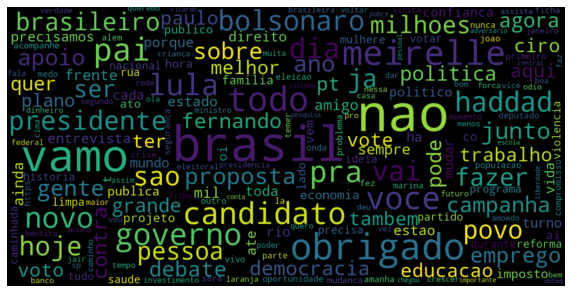

In [9]:
#Nuvem de palavras após tratamento
nuvem_palavras(df["mensagem_tratada"])

In [10]:
todas_palavras = ' '.join([texto for texto in df["mensagem_tratada"]])
frequencia = nltk.FreqDist(token_espaco.tokenize(todas_palavras))
df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                             "Frequência": list(frequencia.values())})
df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = 10)
df_frequencia

,Palavra,Frequência
6,nao,2465
112,brasil,2203
327,vamos,1860
113,obrigado,1147
4492,meirelles,1004
389,pais,833
2207,lula,741
56,pra,731
142,novo,708
5,voce,690


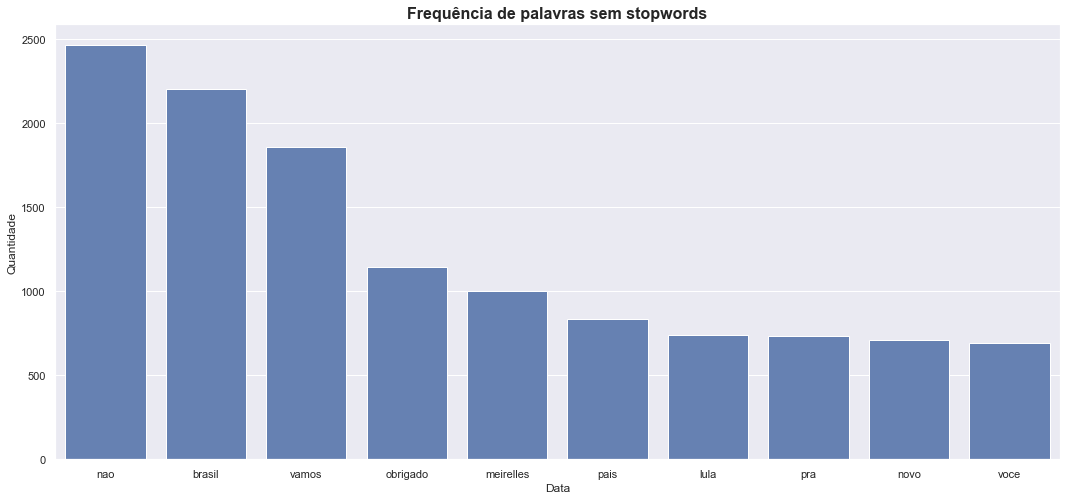

In [11]:
#Grafico palavras mais relevantes
df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = 10)
plt.figure(figsize=(18,8))
ax = sns.barplot(data = df_frequencia, x= "Palavra", y = "Frequência", color="#597DBF",ci=None)
ax.set(ylabel = "Quantidade", xlabel = "Data")
plt.title('Frequência de palavras sem stopwords', fontsize=16, fontweight='bold')
plt.show()

### Após tratamento das mensagens, é utilizado o Vader como forma de classificar os sentimentos encontrados nos tweets como positivos, negativos e neutros

In [12]:
#Analisar sentimentos das mensagens
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def analise_mensagem(texto):
    sentimento_msg = list()
    for t in texto:
        df_analisado = analyzer.polarity_scores(t)['compound'] 
        sentimento_msg.append(df_analisado)
    return sentimento_msg

df["compound"] = analise_mensagem(df["mensagem_tratada"])

In [13]:
# aplicando a função e guardando na coluna new_review
df_pos = df[(df['compound'] > 0.05)]
df_neg = df[(df['compound'] < -0.05)]
df_neutro = df[(df['compound'] >= -0.05) & (df['compound'] <= 0.05)]

print("Frase tratada:\n")
print('Positivos: {}.'.format(len(df_pos)))
print('Negativos: {}.'.format(len(df_neg)))
print('Neutros: {}.'.format(len(df_neutro)))

Frase tratada:

Positivos: 5024.
Negativos: 2917.
Neutros: 3084.


In [14]:
# aplicando a função e guardando na coluna new_review
def classifica_sentimento(compound):
    sentimento = 'neutro'
    if(compound <= -0.05):
        sentimento = 'negativo'
    elif(compound >= 0.05):
        sentimento = 'positivo'
    return sentimento

df.loc[:, 'review'] = df.compound.apply(lambda x: classifica_sentimento(x))

In [15]:
df.head()

,tweet,num_retweets,num_likes,user,data,data_resumo,dia_semana,mensagem,mensagem_tratada,compound,review
0,NAÇÃO BRASILEIRA. Conh...,55,839,cabodaciolo,2018-10-27,27/10,Sab,nacao brasileira conheco as suas obras sei que...,nacao brasileira conheco obras sei voce nao fr...,0.4019,positivo
1,Seguirei o caminho da integridade;quando virás...,59,1094,cabodaciolo,2018-10-27,27/10,Sab,seguirei o caminho da integridade quando viras...,seguirei caminho integridade viras encontro ca...,0.3818,positivo
3,Voto em cédulas JÁ!Glória a Deus https://t.co/...,107,871,cabodaciolo,2018-10-20,20/10,Sab,voto em cedulas ja gloria a deus,voto cedulas ja gloria deus,0.6808,positivo
4,@isamovitz Deus abençoe,0,12,cabodaciolo,2018-10-18,18/10,Qui,deus abencoe,deus abencoe,0.5994,positivo
5,"Eu posso ser crente menino, mas não adultero.E...",574,4296,cabodaciolo,2018-10-18,18/10,Qui,eu posso ser crente menino mas nao adultero eu...,posso ser crente menino nao adultero posso ser...,-0.5267,negativo


In [16]:
#Tweets por review
df_qtde_reviews = df.groupby(['review']).size().reset_index(name='quantidade')
df_qtde_reviews.head()

,review,quantidade
0,negativo,2917
1,neutro,3084
2,positivo,5024


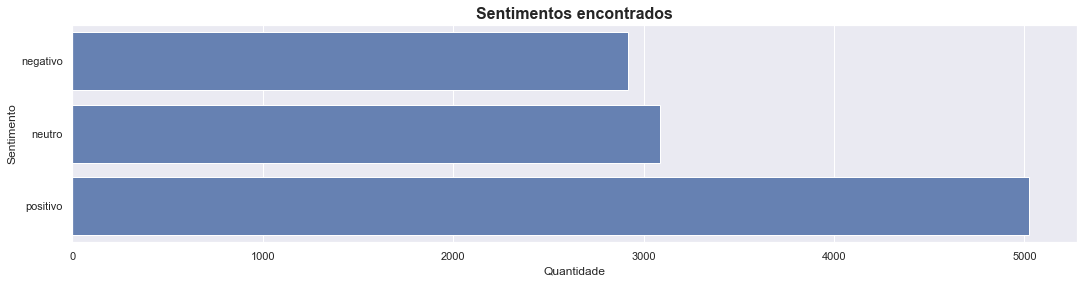

In [17]:
#Gráfico Total de tweets por candidato
df_qtde_reviews.nlargest(columns = "quantidade", n = 5)
plt.figure(figsize=(18,4))
ax = sns.barplot(data = df_qtde_reviews, y= "review", x = "quantidade"
                 , color="#597DBF"
                 ,orient = 'h'
                 ,ci=None)
ax.set(ylabel = "Sentimento", xlabel = "Quantidade")
plt.title('Sentimentos encontrados', fontsize=16, fontweight='bold')
plt.show()

### Testar se a classificação do sentimento tem fundamento

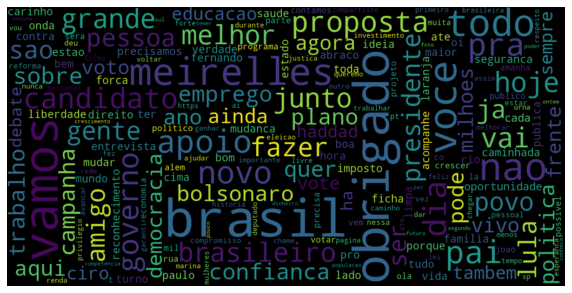

In [18]:
#Verifica nuvem de palavras positivas após classificação do sentimento
df_mensagem_pos = df[(df["review"] == 'positivo')]
nuvem_palavras(df_mensagem_pos["mensagem_tratada"])

In [19]:
df_mensagem_pos["mensagem"].iloc[0]

'nacao brasileira conheco as suas obras sei que voce nao e frio nem quente melhor seria que fosse frio ou quente assim porque voce e morno nao e frio nem ...'

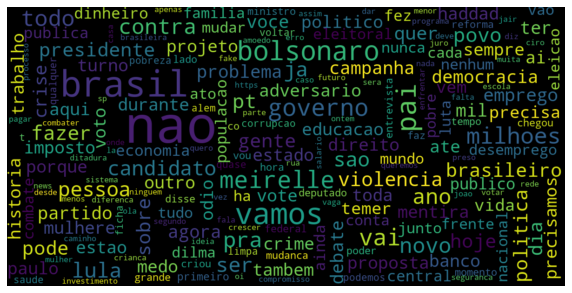

In [20]:
#Verifica nuvem de palavras negativas após classificação do sentimento
df_mensagem_neg = df[(df["review"] == 'negativo')]
nuvem_palavras(df_mensagem_neg["mensagem_tratada"])

In [21]:
df_mensagem_neg["mensagem"].iloc[0]

'eu posso ser crente menino mas nao adultero eu posso ser crente menino mas eu nao me vendo'

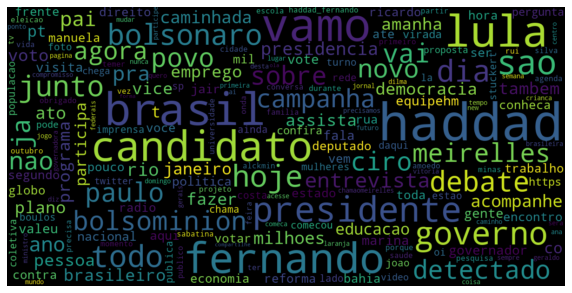

In [22]:
#Verifica nuvem de palavras neutras após classificação do sentimento
df_mensagem_neutra = df[(df["review"] == 'neutro')]
nuvem_palavras(df_mensagem_neutra["mensagem_tratada"])

In [23]:
df_mensagem_neutra["mensagem"].iloc[0]

'fake news amiga'

### Acurácia do modelo

In [24]:
#Ajustar review para classificador
classificacao = df["review"].replace(["negativo", "positivo", "neutro"],[-1, 0, 1])
df["classificacao"] = classificacao

In [25]:
df.head()

,tweet,num_retweets,num_likes,user,data,data_resumo,dia_semana,mensagem,mensagem_tratada,compound,review,classificacao
0,NAÇÃO BRASILEIRA. Conh...,55,839,cabodaciolo,2018-10-27,27/10,Sab,nacao brasileira conheco as suas obras sei que...,nacao brasileira conheco obras sei voce nao fr...,0.4019,positivo,0
1,Seguirei o caminho da integridade;quando virás...,59,1094,cabodaciolo,2018-10-27,27/10,Sab,seguirei o caminho da integridade quando viras...,seguirei caminho integridade viras encontro ca...,0.3818,positivo,0
3,Voto em cédulas JÁ!Glória a Deus https://t.co/...,107,871,cabodaciolo,2018-10-20,20/10,Sab,voto em cedulas ja gloria a deus,voto cedulas ja gloria deus,0.6808,positivo,0
4,@isamovitz Deus abençoe,0,12,cabodaciolo,2018-10-18,18/10,Qui,deus abencoe,deus abencoe,0.5994,positivo,0
5,"Eu posso ser crente menino, mas não adultero.E...",574,4296,cabodaciolo,2018-10-18,18/10,Qui,eu posso ser crente menino mas nao adultero eu...,posso ser crente menino nao adultero posso ser...,-0.5267,negativo,-1


In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

### Uso do Naive Bayes

In [27]:
#Utilização do classificador NaiveBayes

tf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), lowercase=True, use_idf=True,
                                strip_accents='unicode')

#Variáveis de treinamento
treino_x = tf_vectorizer.fit_transform(df['mensagem_tratada'])
treino_y = df['review']

#Modelo
cls_MNB = MultinomialNB()
# Treinamento do modelo:
cls_MNB.fit(treino_x, treino_y)

MultinomialNB()

In [28]:
#Teste do modelo
teste_x = tf_vectorizer.transform(df['mensagem_tratada'])
teste_y = df['review']

# Aplicação do modelo nos dados de teste:
predict_MNB_test = cls_MNB.predict(teste_x)
result_MNB_test = pd.Series(predict_MNB_test)
# Resultados da análise nos dados de teste:
result_MNB_test.value_counts()

positivo    7035
negativo    2246
neutro      1744
dtype: int64

In [29]:
#Precisão do modelo Naive Bayes
print(classification_report(teste_y, predict_MNB_test))
print("Acurácia de previsão:", accuracy_score(teste_y, predict_MNB_test))

              precision    recall  f1-score   support

    negativo       0.91      0.70      0.80      2917
      neutro       0.95      0.54      0.69      3084
    positivo       0.70      0.98      0.82      5024

    accuracy                           0.78     11025
   macro avg       0.86      0.74      0.77     11025
weighted avg       0.83      0.78      0.77     11025

Acurácia de previsão: 0.7830385487528345


### Uso da regressão logística

In [30]:
tfidf = TfidfVectorizer(lowercase=False)
tfidf_bruto = tfidf.fit_transform(df["mensagem_tratada"])
treino_x, teste_x, treino_y, teste_y = train_test_split(tfidf_bruto,
                                                             df["review"],
                                                             random_state = 42)
    
regressao_logistica = LogisticRegression(solver="lbfgs")
regressao_logistica.fit(treino_x, treino_y)

LogisticRegression()

In [31]:
# Aplicação do modelo nos dados de teste:
predict_reglog = regressao_logistica.predict(teste_x)
result_reglog = pd.Series(predict_reglog)
# Resultados da análise nos dados de teste:
result_reglog.value_counts()

positivo    1287
neutro       816
negativo     654
dtype: int64

In [32]:
#Precisão do modelo Regressão Logística
print(classification_report(teste_y, predict_reglog))
print("Acurácia de previsão:", accuracy_score(teste_y, predict_reglog))

              precision    recall  f1-score   support

    negativo       0.81      0.74      0.77       708
      neutro       0.79      0.80      0.80       812
    positivo       0.83      0.87      0.85      1237

    accuracy                           0.81      2757
   macro avg       0.81      0.80      0.81      2757
weighted avg       0.81      0.81      0.81      2757

Acurácia de previsão: 0.8146536089952847


### Criar novo arquivo após tratamento

In [33]:
df.to_csv('../Dataset/tweet_candidatos_eleicoes_2018_classificado.csv', sep=';', index=False)